In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("talk")


In [2]:
df = pd.read_csv('../test_rutherford_brainmask/test_dice.csv')
#sns.displot(df,x='dice')

df.set_index('id')

,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard
id,,,,,
sub-2006_ses-T1_task-rest_vol-0,8237,7594,7170,0.905818,0.827849
sub-2006_ses-T1_task-rest_vol-1,8485,7683,7327,0.906358,0.828752
sub-2006_ses-T1_task-rest_vol-2,8622,7538,7365,0.911510,0.837408
sub-2006_ses-T1_task-rest_vol-3,8847,7618,7482,0.908837,0.832907
sub-2006_ses-T1_task-rest_vol-4,8779,7615,7396,0.902281,0.821960
...,...,...,...,...,...
sub-2228_ses-T2_task-rest_vol-1,9228,8735,8615,0.959194,0.921588
sub-2228_ses-T2_task-rest_vol-2,9324,8789,8674,0.957765,0.918953
sub-2228_ses-T2_task-rest_vol-3,9325,8993,8749,0.955235,0.914307


In [3]:
#get list of bad volumes (those where manual mask extends past the bold -- bids dataset has incorrect cropping for some subjects that causes this)

df_bad = pd.read_table('../test_rutherford_brainmask/bad_vols.txt',
                      sep=' ',names=['subject','session','task','vol'])
df_bad

def map_vol(vol):
    return f'vol-{vol}'

bad_ids = ['_'.join(i) for i in zip(df_bad['subject'].map(str),df_bad['session'].map(str),df_bad['task'].map(str),df_bad['vol'].map(map_vol))]

df_bad = pd.DataFrame(bad_ids,columns=['id'])
df_bad

,id
0,sub-2013_ses-T1_task-rest_vol-6
1,sub-2013_ses-T1_task-rest_vol-7
2,sub-2013_ses-T1_task-rest_vol-8
3,sub-2013_ses-T1_task-rest_vol-9
4,sub-2013_ses-T1_task-rest_vol-10
...,...
269,sub-2229_ses-T1_task-rest_vol-4
270,sub-2229_ses-T1_task-rest_vol-5
271,sub-2229_ses-T1_task-rest_vol-6
272,sub-2230_ses-T2_task-rest_vol-7


In [4]:
#pd.merge(df,df_bad,left_on='id',right_on='id')



df = (pd.merge(df,df_bad, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))


In [5]:
#have confirmed that Dice <0.7 are errors in manual seg

df3d = df[df['dice'] > 0.7 ]


In [6]:
df2d = pd.read_csv('../test_rutherford_brainmask/test_rutherfordunet_dice.csv')
df = pd.merge(df3d,df2d,left_on='id',right_on='id',suffixes=('_nnunet','_rutherford'))

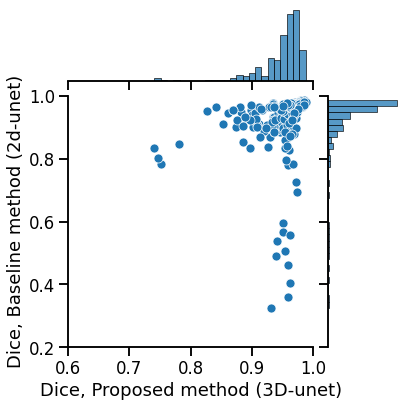

In [7]:
df
g = sns.jointplot(x='dice_nnunet',y='dice_rutherford',data=df,xlim=(0.6,1),ylim=(0.2,1),ratio=3,)
#g.set_xlabel("Dice score, Baseline method (2d-unet)", fontsize = 20)
g.set_axis_labels("Dice, Proposed method (3D-unet)", "Dice, Baseline method (2d-unet)")

g.savefig('dice_scatter_ds3090.svg')

In [8]:
#make table with mean, stdev, and range
print("\\begin{tabular}{|c|c|c|}")
print(f"Dice metric & $\mu \pm  \sigma$  & (min, max) \\\\")
print(f" Proposed method (3D-unet) & ${df['dice_nnunet'].mean():0.2f} \pm {df['dice_nnunet'].std():0.2f}$ & $({df['dice_nnunet'].min():0.2f},{df['dice_nnunet'].max():0.2f} )$ \\\\")
print(f" Baseline method (2D-unet) & ${df['dice_rutherford'].mean():0.2f} \pm {df['dice_rutherford'].std():0.2f}$ & $({df['dice_rutherford'].min():0.2f},{df['dice_rutherford'].max():0.2f} )$ \\\\")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
Dice metric & $\mu \pm  \sigma$  & (min, max) \\
 Proposed method (3D-unet) & $0.95 \pm 0.04$ & $(0.74,0.99 )$ \\
 Baseline method (2D-unet) & $0.92 \pm 0.10$ & $(0.33,0.99 )$ \\
\end{tabular}


In [9]:
#make vert concat table
group = ['Proposed (3D-unet)' for i in range(len(df3d))] + ['Baseline (2D-unet)' for i in range(len(df3d))]
df = pd.DataFrame(pd.concat((df['dice_nnunet'],df['dice_rutherford']),ignore_index=True),columns=['dice'])
df['group']=group

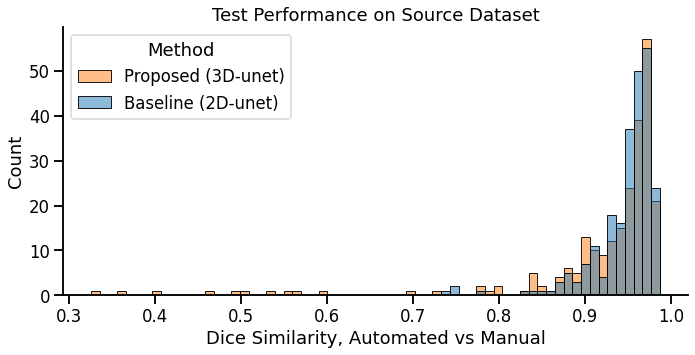

In [10]:

g = sns.displot(data=df, x="dice", hue="group",aspect=2,legend=False,log_scale=(False,False))
plt.legend(title='Method', loc='upper left', labels=['Baseline (2D-unet)','Proposed (3D-unet)'])
g.set_axis_labels("Dice Similarity, Automated vs Manual", "Count")
plt.title('Test Performance on Source Dataset')

g.savefig('dice_ds3090.svg')

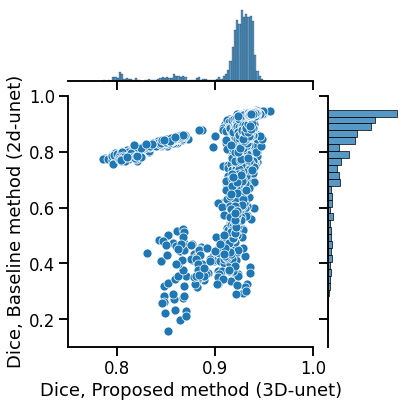

In [11]:
#load up generalization data
df3d = pd.read_csv('../brainmask_FIND/test_dice.csv',dtype={'voxels_manual':np.int32})
df2d = pd.read_csv('../brainmask_FIND/test_rutherfordunet_dice.csv',dtype={'voxels_manual':np.int32})

df = pd.merge(df3d,df2d,left_on='id',right_on='id',suffixes=('_nnunet','_rutherford'))

g = sns.jointplot(x='dice_nnunet',y='dice_rutherford',data=df,xlim=(0.75,1),ylim=(0.1,1),ratio=3,)
g.set_axis_labels("Dice, Proposed method (3D-unet)", "Dice, Baseline method (2d-unet)")

g.savefig('dice_scatter_localdata.svg')

In [12]:
#make table with mean, stdev, and range
print("\\begin{tabular}{|c|c|c|}")
print(f"Dice metric & $\mu \pm  \sigma$  & (min, max) \\\\")
print(f" Proposed method (3D-unet) & ${df['dice_nnunet'].mean():0.2f} \pm {df['dice_nnunet'].std():0.2f}$ & $({df['dice_nnunet'].min():0.2f},{df['dice_nnunet'].max():0.2f} )$ \\\\")
print(f" Baseline method (2D-unet) & ${df['dice_rutherford'].mean():0.2f} \pm {df['dice_rutherford'].std():0.2f}$ & $({df['dice_rutherford'].min():0.2f},{df['dice_rutherford'].max():0.2f} )$ \\\\")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
Dice metric & $\mu \pm  \sigma$  & (min, max) \\
 Proposed method (3D-unet) & $0.92 \pm 0.03$ & $(0.79,0.96 )$ \\
 Baseline method (2D-unet) & $0.81 \pm 0.15$ & $(0.16,0.95 )$ \\
\end{tabular}


In [13]:
#instead of merge, we can concat (while keeping groups separate) to enable overlapping histograms

group = ['Proposed (3D-unet)' for i in range(len(df3d))] + ['Baseline (2D-unet)' for i in range(len(df3d))]
df = pd.concat((df3d,df2d),ignore_index=True)
df['group'] = group
df

,id,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard,group
0,sub-S1_ses-1_task-rest_vol-0,5875,5556,5296,0.926603,0.863244,Proposed (3D-unet)
1,sub-S1_ses-1_task-rest_vol-1,6157,5893,5604,0.930124,0.869376,Proposed (3D-unet)
2,sub-S1_ses-1_task-rest_vol-2,5885,5697,5309,0.916767,0.846326,Proposed (3D-unet)
3,sub-S1_ses-1_task-rest_vol-3,5853,5549,5322,0.933520,0.875329,Proposed (3D-unet)
4,sub-S1_ses-1_task-rest_vol-4,6098,5688,5462,0.926862,0.863694,Proposed (3D-unet)
...,...,...,...,...,...,...,...
4175,sub-S9_ses-1_task-rest3_vol-105,8948,4593,3979,0.587697,0.416126,Baseline (2D-unet)
4176,sub-S9_ses-1_task-rest3_vol-106,9007,4492,3814,0.565079,0.393805,Baseline (2D-unet)
4177,sub-S9_ses-1_task-rest3_vol-107,8973,4305,3683,0.554752,0.383846,Baseline (2D-unet)
4178,sub-S9_ses-1_task-rest3_vol-108,8838,4579,3888,0.579563,0.408018,Baseline (2D-unet)


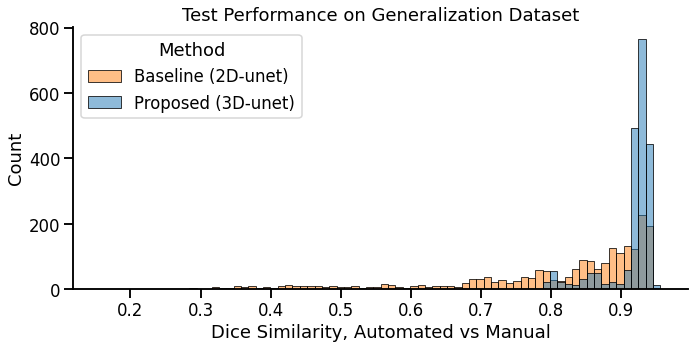

In [16]:
g = sns.displot(data=df, x="dice", hue="group",aspect=2,legend=False,log_scale=(False,False))
plt.legend(title='Method', loc='upper left', labels=['Baseline (2D-unet)','Proposed (3D-unet)'])
g.set_axis_labels("Dice Similarity, Automated vs Manual", "Count")
plt.title('Test Performance on Generalization Dataset')

g.savefig('dice_localdata.svg')

In [15]:
df.voxels_manual

0       5875
1       6157
2       5885
3       5853
4       6098
        ... 
4175    8948
4176    9007
4177    8973
4178    8838
4179    8902
Name: voxels_manual, Length: 4180, dtype: int32

In [16]:
df

,id,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard,group
0,sub-S1_ses-1_task-rest_vol-0,5875,5556,5296,0.926603,0.863244,Proposed (3D-unet)
1,sub-S1_ses-1_task-rest_vol-1,6157,5893,5604,0.930124,0.869376,Proposed (3D-unet)
2,sub-S1_ses-1_task-rest_vol-2,5885,5697,5309,0.916767,0.846326,Proposed (3D-unet)
3,sub-S1_ses-1_task-rest_vol-3,5853,5549,5322,0.933520,0.875329,Proposed (3D-unet)
4,sub-S1_ses-1_task-rest_vol-4,6098,5688,5462,0.926862,0.863694,Proposed (3D-unet)
...,...,...,...,...,...,...,...
4175,sub-S9_ses-1_task-rest3_vol-105,8948,4593,3979,0.587697,0.416126,Baseline (2D-unet)
4176,sub-S9_ses-1_task-rest3_vol-106,9007,4492,3814,0.565079,0.393805,Baseline (2D-unet)
4177,sub-S9_ses-1_task-rest3_vol-107,8973,4305,3683,0.554752,0.383846,Baseline (2D-unet)
4178,sub-S9_ses-1_task-rest3_vol-108,8838,4579,3888,0.579563,0.408018,Baseline (2D-unet)
